# Synthetic Control

This NB serves as a tutorial on how to run power analysis using synthetic control analysis. It considers that looking at some time frame and some clusters, one of the clusters will receive a treatment and the rest remain in control. This treatment cluster will receive some effect from the Perturbator. Then, we run a power analysis to understand how many times we can capture this perturbation.  

In the end we compare the results with Clustered OLS method. 

In [92]:
from itertools import product

import numpy as np
import pandas as pd
from cluster_experiments.experiment_analysis import SyntheticControlAnalysis, ClusteredOLSAnalysis
from cluster_experiments.perturbator import ConstantPerturbator
from cluster_experiments.power_analysis import PowerAnalysisWithPreExperimentData, PowerAnalysis
from cluster_experiments.random_splitter import FixedSizeClusteredSplitter
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, labs, theme, element_text, element_blank


def generate_data(N, start_date, end_date):
    dates = pd.date_range(start_date, end_date, freq="d")

    users = [f"User {i}" for i in range(N)]

    combinations = list(product(users, dates))

    target_values = np.random.normal(100, 10, size=len(combinations))

    df = pd.DataFrame(combinations, columns=["user", "date"])
    df["target"] = target_values


    return df




In [93]:
df = generate_data(50, "2022-01-01", "2022-01-30")
intervention_date = "2022-01-15"
effects = [0, 1, 2, 5, 10, 15]



The graph below shows the evolution of target for each user. When running the synthetic control analysis:
- Select randomly one user to be in treatment group. 
- Use pre experiment data (in this case case from 1 to 15th of Jan) to find the best combination of weights 
- Apply weights to donors and generate synthetic control user 

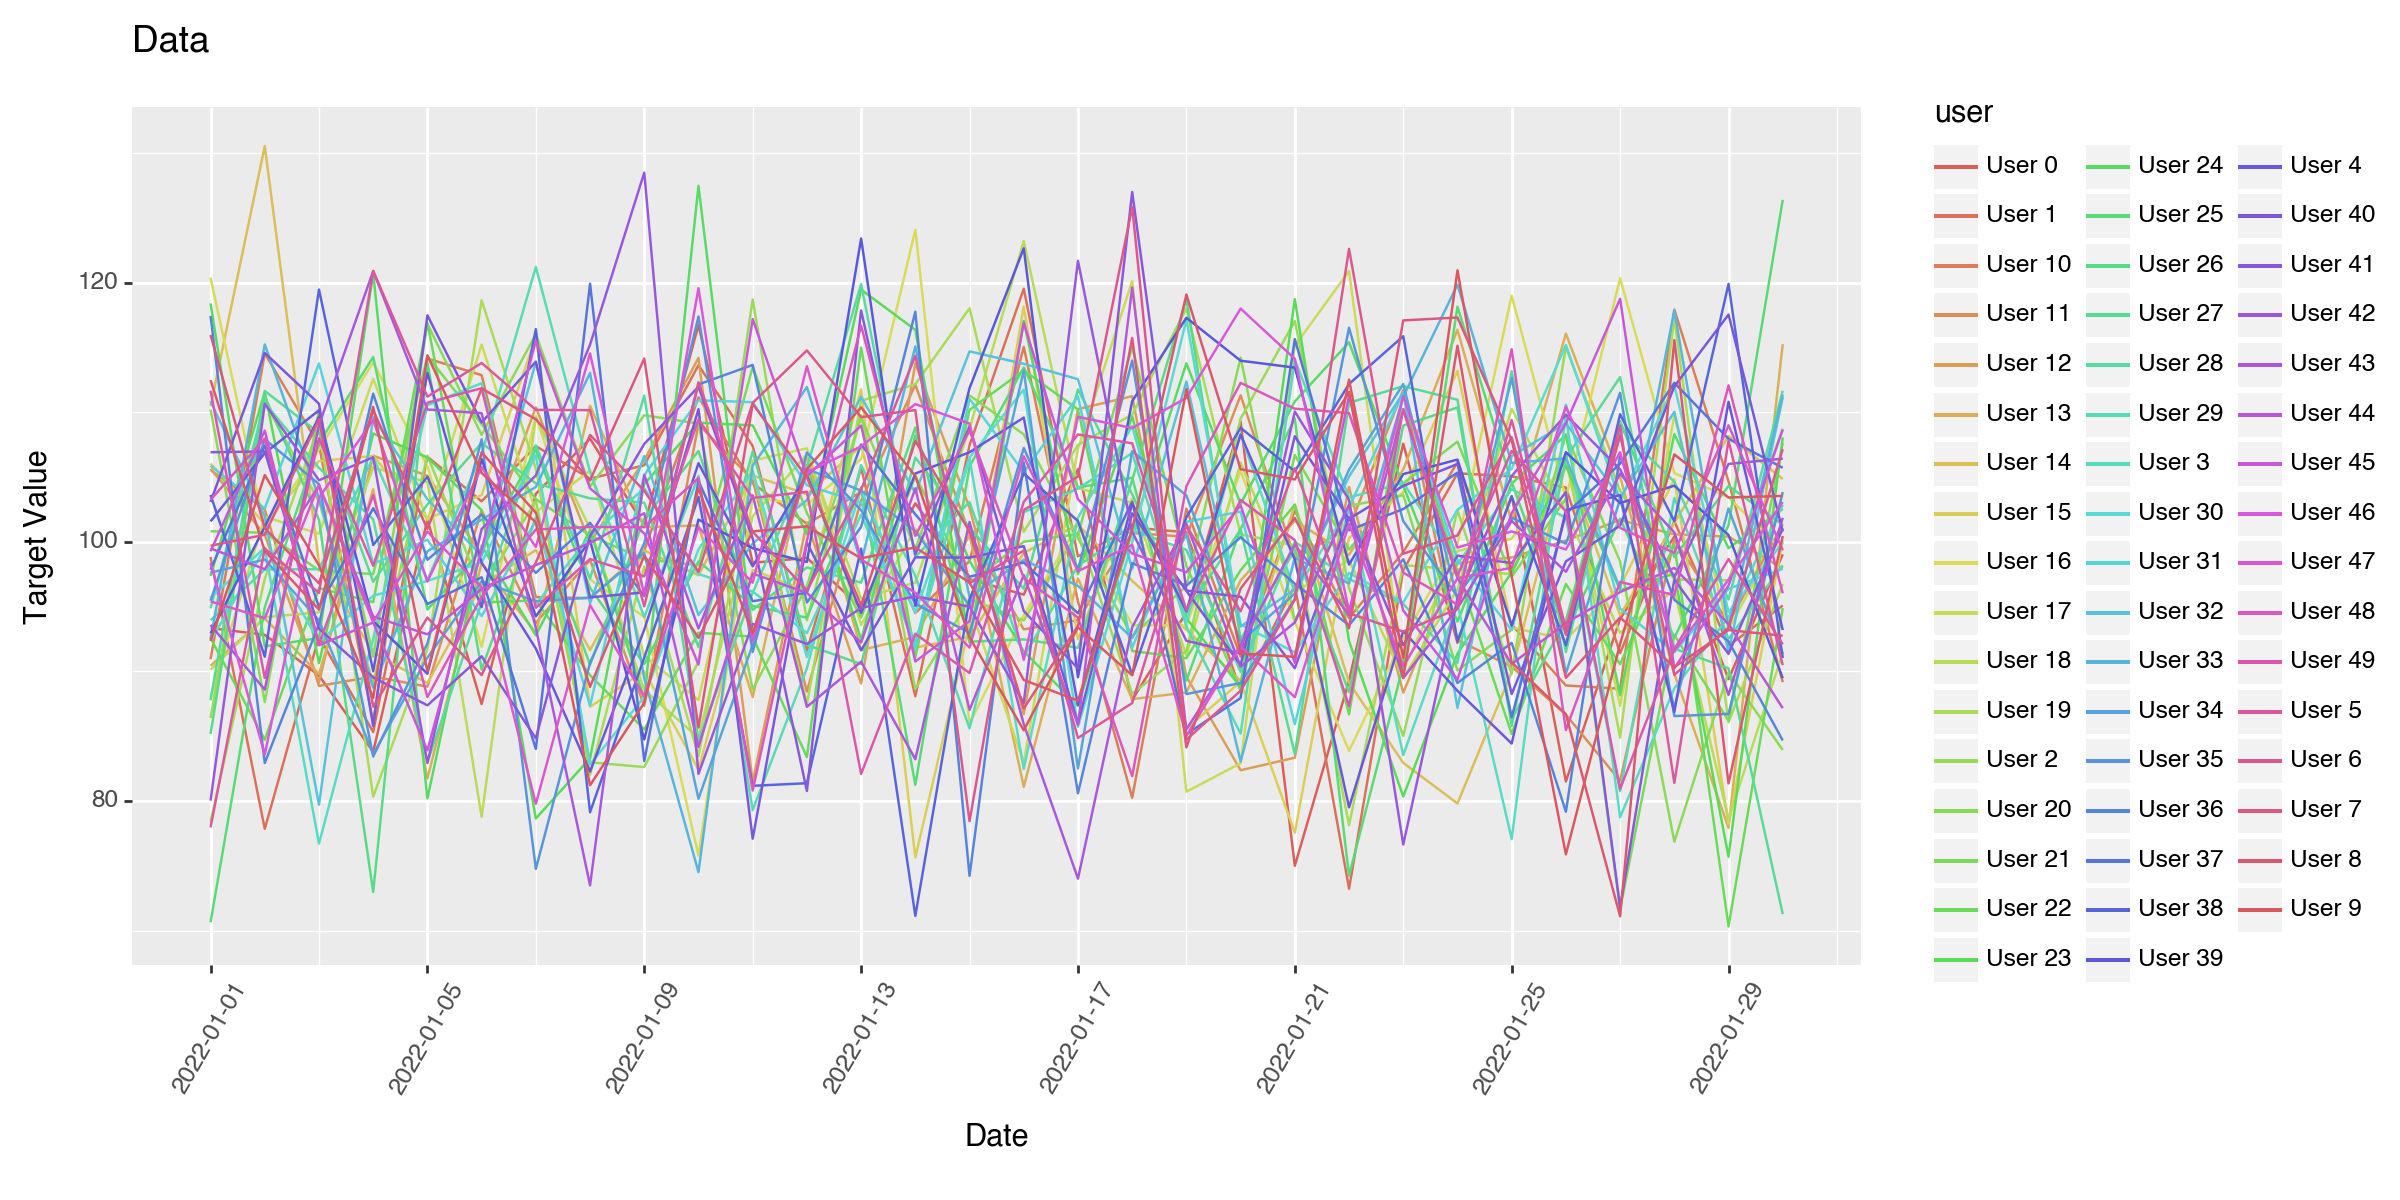

<Figure Size: (1200 x 600)>

In [94]:
(ggplot(df, aes(x="date", y="target", color = 'user')) 
 + geom_line() 
 + labs(title="Data", x="Date", y="Target Value") 
 + theme(axis_text_x=element_text(angle=60), figure_size=(12, 6)))


In [95]:
sw = FixedSizeClusteredSplitter(n_treatment_clusters=1, cluster_cols=["user"])

perturbator = ConstantPerturbator(
    average_effect=0,
)

analysis = SyntheticControlAnalysis(
    cluster_cols=["user"], time_col="date", intervention_date=intervention_date
)

pw = PowerAnalysisWithPreExperimentData(
     splitter=sw, analysis=analysis, n_simulations=50, perturbator=perturbator
)


p_synth = pw.power_line(df, average_effects=effects, n_jobs=-1)


KeyboardInterrupt: 

# Comparison with OLS

In [89]:
analysis = ClusteredOLSAnalysis(
    cluster_cols=["user"] )

pw = PowerAnalysis(
    perturbator=perturbator, splitter=sw, analysis=analysis, n_simulations=200
)

df = df.query(f"date > '{intervention_date}'")

p_ols = pw.power_line(df, average_effects=effects, n_jobs=-1)

# todo add time to run 

In [90]:
synth_df = pd.DataFrame({'effect' : p_synth.keys(), 
              'method': 'Synthetic',
              'power': p_synth.values()})

ols_df = pd.DataFrame({'effect' : p_ols.keys(), 
              'method': 'OLS',
              'power': p_ols.values()})

df_results = pd.concat([synth_df, ols_df])

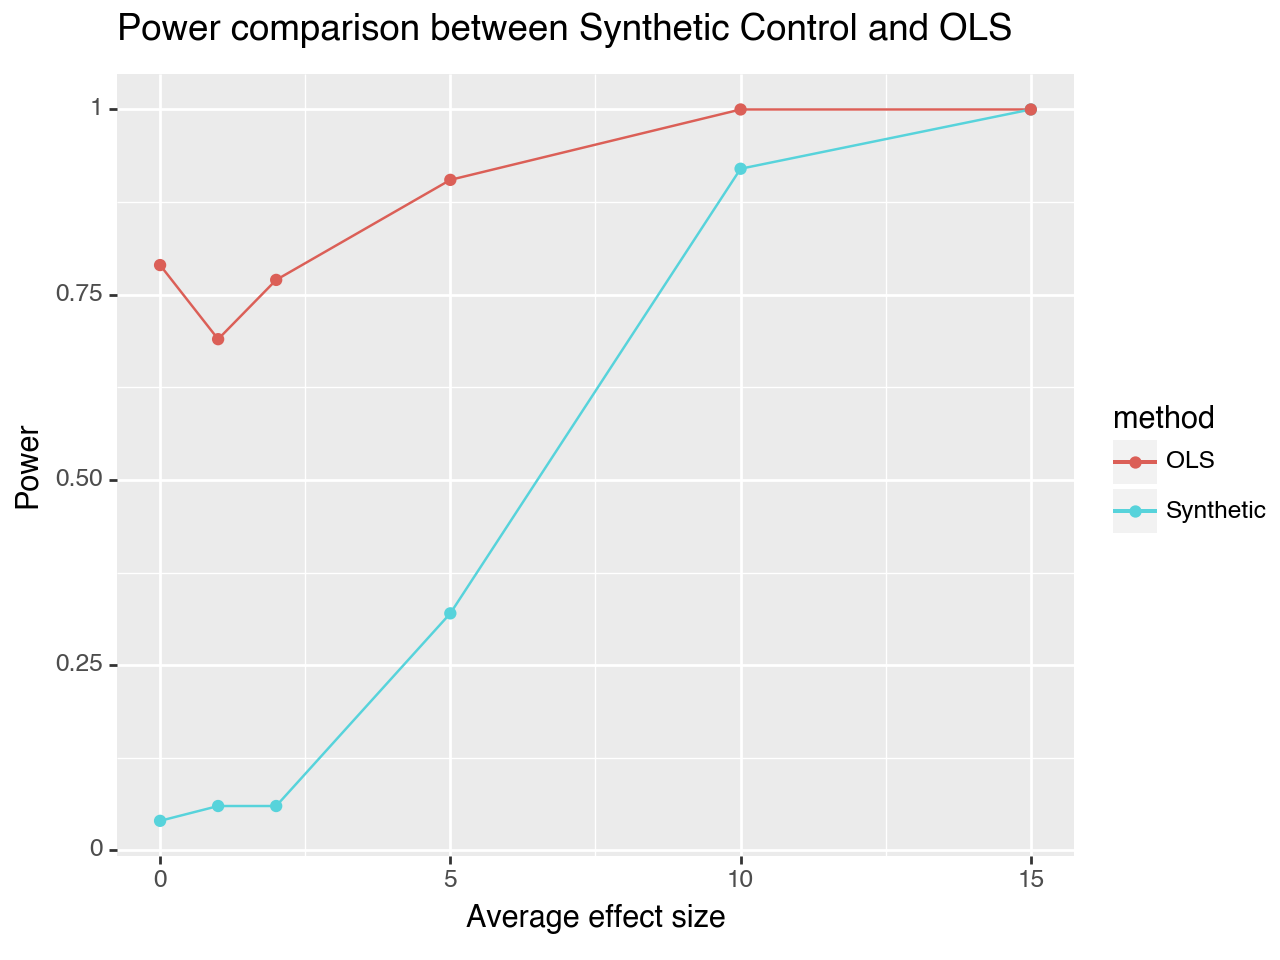

<Figure Size: (640 x 480)>

In [91]:
(
ggplot(df_results, aes(x='effect', y='power', color='method')) 
+ geom_line() 
+ geom_point()
+ labs(
    title="Power comparison between Synthetic Control and OLS",
    x="Average effect size", y="Power"

))